In [1]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import warnings
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from helpers import create_df
from helpers import get_peaks_and_valleys
from helpers import plot_df
from helpers import get_num_reps
from helpers import smooth_and_resample
from helpers import segment_into_reps
from helpers import add_barbell_features

from tcn import TCN
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GRU
from mpl_toolkits.mplot3d import Axes3D



In [2]:
# 0 = bicep curl, 1 = shoulder press, 2 = row, 3 = rdl, 4 = squat 
training_files = {"../data2/bicep_curl/bicep_adam_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_mike_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_udai_set1_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv": 1,
                  "../data2/row/row_adam_set1_reps10_1.csv": 2, 
                  "../data2/row/row_andrew_set1_reps10_1.csv": 2, 
                  "../data2/row/row_anuj_set1_rep10_1.csv": 2, 
                  "../data2/row/row_jake_set1_reps12_1.csv": 2, 
                  "../data2/row/row_kamyar_set1_reps10_1.csv": 2, 
                  "../data2/row/row_mike_set1_reps10_1.csv": 2, 
                  "../data2/row/row_suzan_set1_reps10_1.csv": 2, 
                  "../data2/row/row_udai_set1_reps12_1.csv": 2, 
                  "../data2/dead/dead_adam_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_andrew_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_anuj_set1_rep10_1.csv": 3, 
                  "../data2/dead/dead_kamyar_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_mike_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_adam_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_andrew_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_anuj_set1_rep10_1.csv": 4, 
                  "../data2/squat/squat_jake_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_kamyar_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_mike_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_suzan_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_udai_set1_reps10_1.csv": 4,
                  "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv": 1, 
                  "../data2/row/row_udai_set3_reps10_1.csv": 2, 
                  "../data2/dead/dead_udai_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_udai_set3_reps10_1.csv": 4,
                  "../data2/newDead/newdead_udai_set1_reps10_1.csv": 3,
                  "../data2/newDead/newdead_udai_set2_reps10_1.csv": 3} 
train_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3] 

test_files = {"../data2/bicep_curl/bicep_adam_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv": 0, 
              "../data2/bicep_curl/bicep_jake_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_kamyar_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_mike_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_suzan_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_udai_set2_reps10_1.csv": 0, 
              "../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_anuj_set2_rep10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_kamyar_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_mike_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set4_reps10_1.csv": 1,
              "../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv": 1, 
              "../data2/row/row_adam_set2_reps10_1.csv": 2, 
              "../data2/row/row_andrew_set2_reps10_1.csv": 2, 
              "../data2/row/row_anuj_set2_rep10_1.csv": 2, 
              "../data2/row/row_jake_set2_reps12_1.csv": 2, 
              "../data2/row/row_kamyar_set2_reps10_1.csv": 2, 
              "../data2/row/row_mike_set2_reps10_1.csv": 2, 
              "../data2/row/row_suzan_set2_reps12_1.csv": 2, 
              "../data2/row/row_udai_set2_reps12_1.csv": 2, 
              "../data2/dead/dead_adam_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_andrew_set2_reps10_1.csv": 3,
              "../data2/dead/dead_anuj_set2_rep10_1.csv": 3, 
              "../data2/dead/dead_kamyar_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_mike_set2_reps10_1.csv": 3, 
              "../data2/squat/squat_adam_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_andrew_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_anuj_set2_rep10_1.csv": 4, 
              "../data2/squat/squat_jake_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_kamyar_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_mike_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_suzan_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_udai_set2_reps10_1.csv": 4,
              } 

test_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3]

../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z  accel_mag  \
0    2823131   -0.607   -9.600   -2.028   0.089  -0.117  -0.039   9.830627   
1    2823134   -0.607   -9.600   -2.039   0.089  -0.117  -0.039   9.832902   
2    2823138   -0.577   -9.570   -2.039   0.109  -0.123  -0.043   9.801803   
3    2823245   -0.621   -9.514   -2.047   0.049  -0.108  -0.046   9.751515   
4    2823282   -0.650   -9.497   -2.061   0.092  -0.106  -0.046   9.739776   

   gyro_mag  
0  0.152089  
1  0.152089  
2  0.169879  
3  0.127205  
4  0.147702  
peakvals: [(41, 14.597), (181, 5.513), (311, 10.466)]
valleyvals: [(20, -2.389), (165, -13.875)]
peaks: [ 41 181 311], peakvals: [(41, 14.597), (181, 5.513), (311, 10.466)]
valleys: [ 20 165], valleyvals: [(20, -2.389), (165, -13.875)]


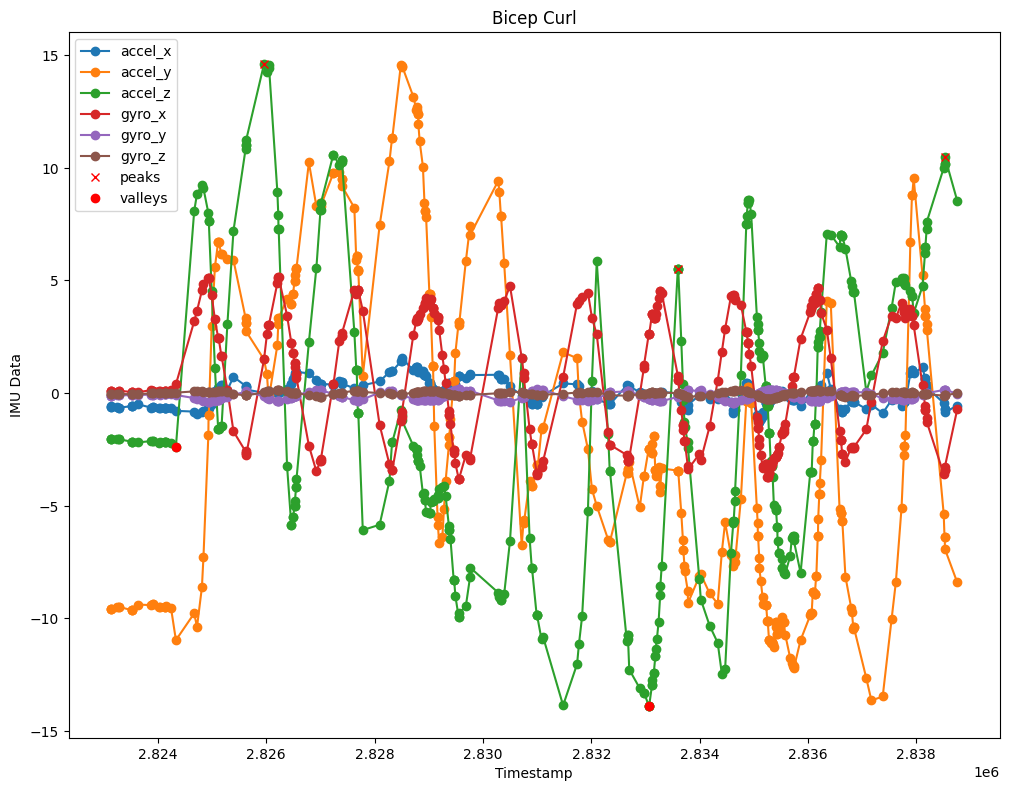

-8.132
valley_outlier_indices: [0 1]
10.192
peak_outlier_indices: []
valid_valley_idxs: []
valid_peak_idxs: [41, 181, 311]
start: 0, end: 313
num_valid_peaks: 3, num_valid_valleys: 0
      timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z  \
0  2.823118e+06 -0.608406 -9.560860 -2.008972  0.105049 -0.120399 -0.033783   
1  2.823143e+06 -0.609987 -9.573118 -2.030265  0.091291 -0.117236 -0.040345   
2  2.823179e+06 -0.610494 -9.579922 -2.050803  0.080123 -0.113815 -0.045354   
3  2.823227e+06 -0.609927 -9.581270 -2.070587  0.071544 -0.110135 -0.048810   
4  2.823285e+06 -0.608285 -9.577163 -2.089615  0.065554 -0.106197 -0.050713   

   accel_mag  gyro_mag  
0   9.788500  0.163003  
1   9.805006  0.154365  
2   9.816000  0.146776  
3   9.821482  0.140239  
4   9.821453  0.134752  


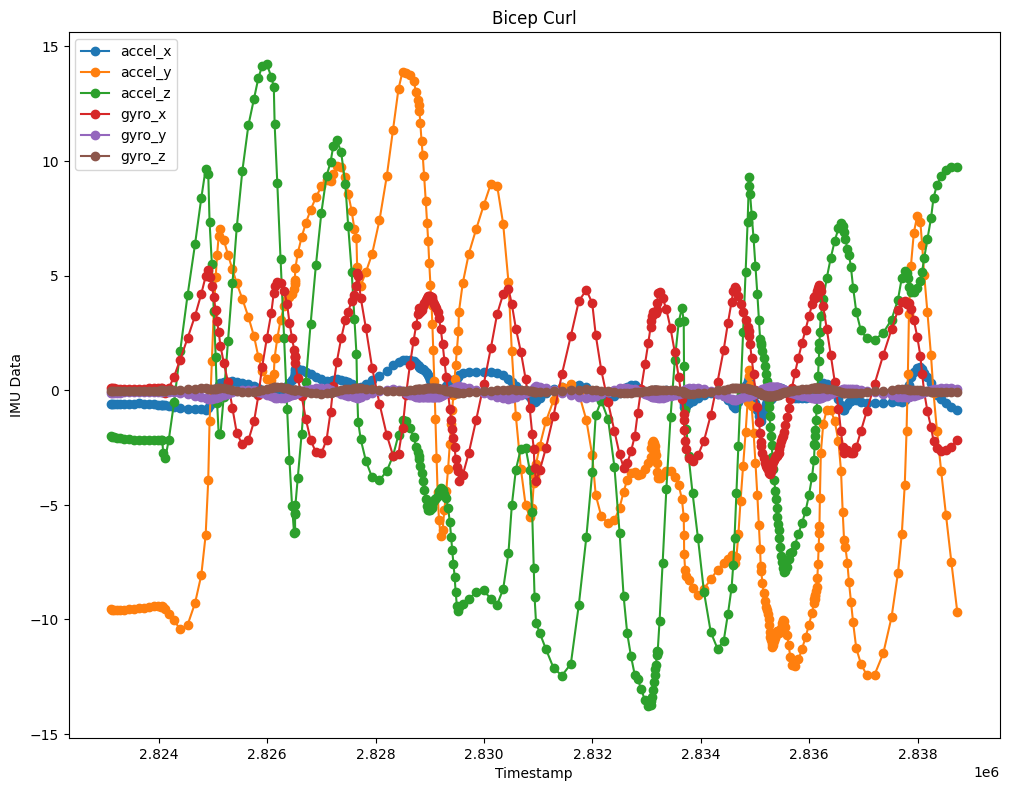

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)

file = "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv"
df = create_df(file)
peaks, valleys, peakvals, valleyvals = get_peaks_and_valleys(df, 120)
plot_df(df, "Bicep Curl", peaks, valleys)
start, end, num_peaks, num_valleys = get_num_reps(df, peakvals, valleyvals)

df = df.iloc[start:end]
df = smooth_and_resample(df)
plot_df(df, "Bicep Curl")

In [4]:
def cropped_df(file):
    df = create_df(file)
    peaks, valleys, peakvals, valleyvals = get_peaks_and_valleys(df, 120)
    start, end, num_peaks, num_valleys = get_num_reps(df, peakvals, valleyvals)
    # df = df.iloc[start:end]
    print(f"file: {file}, len(df): {len(df)}")
    return df

In [5]:
X_train = []
X_test = []
y_train = []
y_test = []
max_len = 100

# Process training files
for file, label in training_files.items():  # Need the label!
    df = cropped_df(file)
    df = add_barbell_features(df)
    # Segment FIRST (on original length data)
    reps = segment_into_reps(df, min_rep_length=15, max_rep_length=500)
    
    # THEN resample each rep individually
    for rep in reps:
        rep_resampled = smooth_and_resample(rep, target_len=100)
        X_train.append(rep_resampled)
        y_train.append(label)  # Add label for each rep

# Process test files
for file, label in test_files.items():  # Need the label!
    df = cropped_df(file)
    df = add_barbell_features(df)
    reps = segment_into_reps(df, min_rep_length=15, max_rep_length=500)
    
    for rep in reps:
        rep_resampled = smooth_and_resample(rep, target_len=100)
        X_test.append(rep_resampled)
        y_test.append(label)  # Add label for each rep

rep_lengths = [len(rep) for rep in X_train + X_test]
target_length = int(np.median(rep_lengths))
#y_train = np.array(list(training_files.values()))
# y_validation = np.array(validation_labels)
#y_test = np.array(list(test_files.values()))

../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z  accel_mag  \
0     304079   -0.834    3.319    9.444   0.098  -0.054   0.012  10.044922   
1     304082   -0.824    3.326    9.452   0.098  -0.054   0.012  10.053932   
2     304085   -0.824    3.326    9.452   0.097  -0.053   0.012  10.053932   
3     304089   -0.824    3.326    9.452   0.097  -0.053   0.012  10.053932   
4     304110   -0.846    3.269    9.446   0.122  -0.056   0.007  10.031400   

   gyro_mag  
0  0.112534  
1  0.112534  
2  0.111185  
3  0.111185  
4  0.134421  
peakvals: [(70, 11.841), (258, 12.548), (450, 12.47), (640, 12.22), (817, 12.367), (999, 12.099), (1188, 12.439), (1366, 12.207), (1562, 12.272), (1752, 12.193), (1910, 11.174)]
valleyvals: [(142, -5.234), (330, -7.138), (527, -7.144), (710, -7.452), (904, -7.908), (1075, -8.465), (1264, -9.249), (1455, -8.989), (1631, -8.171), (1821, -8.157)]
peaks: [  70  258  450  640  817  999 1188 1366 1562

/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/num

       timestamp   accel_x   accel_y    accel_z    gyro_x    gyro_y    gyro_z  \
0  246448.377622  0.237238 -3.158545  15.667755 -0.209385 -0.038203 -0.044469   
1  246453.004686  0.304525 -3.111537  15.820868 -0.227678 -0.030758 -0.045871   
2  246480.323185  0.308935 -2.860330  15.188901 -0.261562 -0.018256 -0.052962   
3  246534.440136  0.244729 -2.310833  13.633068 -0.342813  0.007218 -0.067859   
4  246596.428269  0.127819 -1.830920  11.774975 -0.383087  0.022050 -0.083125   

   accel_mag  gyro_mag  
0  15.983524  0.216428  
1  16.127259  0.234710  
2  15.461983  0.269110  
3  13.835284  0.350572  
4  11.919804  0.389431  
       timestamp   accel_x   accel_y    accel_z    gyro_x    gyro_y    gyro_z  \
0  249686.643357 -0.472329 -4.406811  16.198622  0.390503 -0.197035 -0.024503   
1  249721.361932 -0.263150 -3.363214  15.519991  0.307550 -0.162413 -0.024975   
2  249750.492788 -0.110734 -2.606675  14.856694  0.174262 -0.118907 -0.027150   
3  249773.348873 -0.017854 -2.143618  1

/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/num

      timestamp   accel_x   accel_y    accel_z    gyro_x    gyro_y    gyro_z  \
0  2.940822e+06 -1.646902  5.537580  15.474315  0.372371 -0.018965 -0.053895   
1  2.940843e+06 -1.641293  5.694786  15.273427  0.244420 -0.032624 -0.063387   
2  2.940870e+06 -1.597862  5.610693  14.863785  0.125019 -0.047277 -0.073651   
3  2.940904e+06 -1.508918  5.244106  14.259650 -0.029513 -0.069037 -0.087512   
4  2.940939e+06 -1.398013  4.709339  13.380835 -0.033540 -0.070285 -0.092055   

   accel_mag  gyro_mag  
0  16.517225  0.352838  
1  16.383460  0.264247  
2  15.967951  0.195825  
3  15.269128  0.132747  
4  14.253874  0.128549  
      timestamp   accel_x   accel_y    accel_z    gyro_x    gyro_y    gyro_z  \
0  2.944319e+06 -0.895385  4.833615  14.795776  0.299294 -0.069524 -0.040490   
1  2.944340e+06 -0.930939  5.151343  14.721956  0.264503 -0.021462 -0.069283   
2  2.944370e+06 -1.020066  5.241096  14.564885  0.213494  0.013734 -0.089212   
3  2.944411e+06 -1.115863  5.104852  14.412600  0

/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/num

      timestamp   accel_x    accel_y   accel_z    gyro_x    gyro_y    gyro_z  \
0  2.166318e+06  0.184986  11.513650  5.960713 -0.048720 -0.097266 -0.039909   
1  2.166327e+06  0.244402  11.482387  5.991709 -0.050272 -0.102293 -0.030194   
2  2.166339e+06  0.290285  11.439982  6.007694 -0.051182 -0.107770 -0.021218   
3  2.166354e+06  0.322634  11.386434  6.008666 -0.051450 -0.113696 -0.012981   
4  2.166372e+06  0.341451  11.321745  5.994627 -0.051076 -0.120071 -0.005484   

   accel_mag  gyro_mag  
0  12.966838  0.215391  
1  12.954513  0.189033  
2  12.925152  0.169005  
3  12.878754  0.155304  
4  12.815319  0.147932  
../data2/squat/squat_udai_set3_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z  accel_mag  \
0    1087528    0.754    6.828   -5.371  -0.420  -0.075  -0.084   8.719962   
1    1087532    0.754    6.828   -5.371  -0.580  -0.075  -0.061   8.719962   
2    1087535    0.754    6.828   -5.371  -0.580  -0.075  -0.061   8.719962   
3    1087539 

/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/num

   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z  accel_mag  \
0    3182767   -0.839    3.869    9.868   0.090  -0.119  -0.039  10.632521   
1    3182771   -0.843    3.857    9.927   0.104  -0.116  -0.039  10.683278   
2    3182774   -0.843    3.857    9.927   0.104  -0.116  -0.039  10.683278   
3    3182778   -0.843    3.857   10.002   0.104  -0.116  -0.039  10.753004   
4    3182799   -0.718    3.789    9.845   0.134  -0.106  -0.040  10.573366   

   gyro_mag  
0  0.154214  
1  0.160602  
2  0.160602  
3  0.160602  
4  0.175476  
peakvals: [(3, 10.002), (194, 13.735), (330, 12.815), (461, 13.35), (608, 14.055), (756, 14.474), (902, 13.141), (1040, 14.189), (1176, 13.261), (1324, 13.603), (1492, 13.878), (1617, 12.08)]
valleyvals: []
peaks: [   3  194  330  461  608  756  902 1040 1176 1324 1492 1617], peakvals: [(3, 10.002), (194, 13.735), (330, 12.815), (461, 13.35), (608, 14.055), (756, 14.474), (902, 13.141), (1040, 14.189), (1176, 13.261), (1324, 13.603), (1492, 13

/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/num

       timestamp   accel_x   accel_y    accel_z    gyro_x    gyro_y    gyro_z  \
0  359725.958042 -0.144189  2.617497  14.451266 -0.340231  0.052476 -0.095497   
1  359751.814471 -0.327363  2.367111  14.454995 -0.234722  0.051358 -0.082449   
2  359778.780551 -0.485080  2.155203  14.145854 -0.119756  0.046834 -0.070809   
3  359807.569683 -0.622113  1.952004  13.430297 -0.009840  0.038812 -0.062683   
4  359834.442066 -0.722159  1.858763  12.748082  0.135053  0.027862 -0.051655   

   accel_mag  gyro_mag  
0  14.684345  0.395446  
1  14.652768  0.227745  
2  14.318871  0.131234  
3  13.586366  0.122751  
4  12.903106  0.151610  
       timestamp   accel_x   accel_y    accel_z    gyro_x    gyro_y    gyro_z  \
0  362812.055944 -0.162413  3.219503  14.404916  0.263154  0.043035  0.017608   
1  362845.470745 -0.023205  3.181204  14.146036  0.012829  0.027630 -0.024166   
2  362879.823221  0.031539  3.010358  13.716535 -0.125210  0.013372 -0.047323   
3  362916.157802  0.012599  2.651872  1

/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/j/8803/8803-project/my-venv/lib/python3.13/site-packages/num

In [6]:
print(f"max_len: {max_len}")

def pad(df, max_len):
    feature_cols = ['accel_x', 'accel_y', 'accel_z', 
                    'gyro_x', 'gyro_y', 'gyro_z',
                    'accel_mag', 'gyro_mag']
    
    arr = df[feature_cols].values
    
    if len(arr) >= max_len:
        return arr[:max_len]
    else:
        pad_len = max_len - len(arr)
        pad = np.zeros((pad_len, len(feature_cols)))
        return np.vstack((arr, pad))


max_len: 100


In [7]:
X_train = np.array([pad(df, target_length) for df in X_train])
X_test = np.array([pad(df, target_length) for df in X_test])

X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

print(f"training_files.values(): {list(training_files.values())}")

print("Training samples per class:")
print(np.bincount(y_train))
print("\nTest samples per class:")
print(np.bincount(y_test))

train_mask = np.array(y_train) != 3
test_mask = np.array(y_test) != 3

#X_train_no_dead = X_train[train_mask]
#y_train_no_dead = np.array(y_train)[train_mask]
#X_test_no_dead = X_test[test_mask]
#y_test_no_dead = np.array(y_test)[test_mask]

#print(X_train_no_dead[:5])

num_classes = 5
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train_cat)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test_cat)

training_files.values(): [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3, 3]
Training samples per class:
[65 74 65 56 74]

Test samples per class:
[63 75 64 35 73]


In [8]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

In [9]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 64)         │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,589 (607.77 KB)

 Trainable params: 155,461 (607.27 KB)

 Non-trainable params: 128 (512.00 B)

In [10]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
# param_grid = {
#     'lstm_units': [32, 64, 128],
#     'dropout_rate': [0.2, 0.3, 0.5],
#     'learning_rate': [0.001, 0.0005],
#     'batch_size': [16, 32],
#     'epochs': [30, 50]
# }
# grid = RandomizedSearchCV(estimator=model,
#                           param_distributions=param_grid,
#                           n_iter=10,
#                           cv=3,
#                           verbose=2)
# grid_result = grid.fit(X_train, y_train)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4045 - loss: 1.3211 - val_accuracy: 0.1642 - val_loss: 1.6067
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6479 - loss: 0.9605 - val_accuracy: 0.1343 - val_loss: 1.6763
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7004 - loss: 0.7374 - val_accuracy: 0.1642 - val_loss: 1.8205
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7191 - loss: 0.6139 - val_accuracy: 0.1940 - val_loss: 2.0741
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7940 - loss: 0.5589 - val_accuracy: 0.2836 - val_loss: 1.8665
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7640 - loss: 0.5009 - val_accuracy: 0.1940 - val_loss: 2.1077
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8240 - loss: 0.4279 - val_accuracy: 0.2388 - val_loss: 2.0571
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8652 - loss: 0.3632 - val_accuracy: 0.2090 - val_loss: 2.2645


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (4).

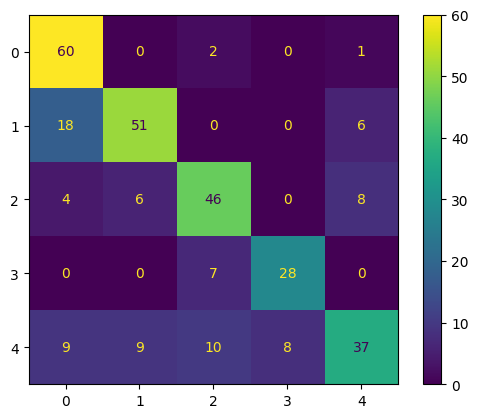

In [ ]:
model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
#class_names = ["bicep_curl", "shoulder_press", "row", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [ ]:
#for i, y in enumerate(y_pred):
#    if y != y_true[i]:
#        print(f"misclassified: {list(test_files.keys())[i]}")

In [ ]:
cnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(64, kernel_size=7, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

In [ ]:
cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# cnn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)

class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
#class_names = ["bicep_curl", "shoulder_press", "row", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [ ]:
#for i, y in enumerate(y_pred):
#    if y != y_true[i]:
#        print(f"misclassified: {list(test_files.keys())[i]}")

In [ ]:
hybrid_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(64, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_model.summary()

In [ ]:
hybrid_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# hybrid_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(hybrid_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
#class_names = ["bicep_curl", "shoulder_press", "row", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [ ]:
tcn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    TCN(nb_filters=64, kernel_size=5, dropout_rate=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

tcn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tcn_model.summary()

In [ ]:
tcn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

In [ ]:
# tcn_model(np.zeros((1, X_train.shape[1], X_train.shape[2])))
# tcn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(tcn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
#class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
class_names = ["bicep_curl", "shoulder_press", "row", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [ ]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = MultiHeadAttention(num_heads=4, key_dim=32)(input_layer, input_layer)
x = LayerNormalization()(x)

x = Dense(128, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

transformer_model = tf.keras.Model(input_layer, output)

transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.summary()

In [ ]:
transformer_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# transformer_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(transformer_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
#class_names = ["bicep_curl", "shoulder_press", "row", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [ ]:
gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    GRU(128, return_sequences=True),
    Dropout(0.3),

    GRU(64),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.summary()


In [ ]:
gru_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# gru_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(gru_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
#class_names = ["bicep_curl", "shoulder_press", "row", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()